In [1]:
import requests
import pandas as pd
import geopandas as gpd

import sys

sys.path.append("../")

# from helper_functions import *
# from loading_data import *
from Code.helper_functions import initial_loading
from Code.algorithms import random_start_hillclimber

POSTGRES password?WelkomCorne!


### Locations per cluster
The first step is to slightly modify the loading of the clusters

In [ ]:
def load_api_data(prnt=False):
    """
    This function loads in information on the current composition of container
    clusters in Amsterdam. It uses the API from data.amsterdam.nl (available at
    'https://api.data.amsterdam.nl/vsd/afvalclusters'). It returns the coordinates,
    amount and volume of different fractions and the address of the clusters. As
    a check, it is determined whether or not the cluster is currently active.
    Returns:
    - df containing coordinates, dict-like amount and volume per fraction and
    address.
    """
    x_coordinates = []
    y_coordinates = []
    aantal = []
    volumes = []
    adresses = []
    buurt = []

    link = 'https://api.data.amsterdam.nl/vsd/afvalclusters'

    while link != None: #This is the case on the last page of the API
        if prnt: # Can be used for some kind of monitoring of progres
            print(link)
        response = requests.get(link)
        output = response.json()
        for result in output['results']:
            if result['cluster_datum_einde_cluster'] == None: #Als het cluster nog actief is
                x_coordinates.append(str(result['cluster_geometrie']['coordinates'][0]))
                y_coordinates.append(str(result['cluster_geometrie']['coordinates'][1]))
                aantal.append(result['cluster_fractie_aantal'])
                volumes.append(result['cluster_fractie_volume'])
                adresses.append(result['bag_adres_openbare_ruimte_naam'])
                buurt.append(result['gbd_buurt_code'])
        try:
            link = output['_links']['next']['href'] #Retrieve link for next page
        except:
            link = None #True for last page of API

    df_clusters = pd.DataFrame([x_coordinates, y_coordinates, aantal, volumes, adresses, buurt]).T
    df_clusters = df_clusters.rename(columns={0: 'cluster_x', 1:'cluster_y', 2:'aantal_per_fractie', 3:'volume_per_fractie', 4: 'street_name', 5:'buurt'})
    # Transform coordinates of clusters to ints, as this helps easing join
    df_clusters['cluster_x'] = df_clusters['cluster_x'].astype('float').round(0).astype('int')
    df_clusters['cluster_y'] = df_clusters['cluster_y'].astype('float').round(0).astype('int')
    df_clusters['wijk'] = df_clusters['buurt'].str[:3]
    df_clusters['stadsdeel'] = df_clusters['buurt'].str[0]
    return df_clusters

In [ ]:
def load_geodata_containers(subsectie=None):
    """
    This function loads in all polygons representing areas in the city of Amsterdam
    where general waste needs to be brought to a container. This is different
    from the alternative where general waste is collected from the sidewalk. This
    is needed to filter the address POI's to relevant POI's for optimization.
    Subsectie is optional parameter to filter on specific stadsdelen. This can be used
    for partial optimization.

    Returns:
    - List of polygons making up the area of centralized garbage collection
    """

    source = gpd.read_file('../data/Inzameling_huisvuil_100220.shp')
    source = source[source['aanbiedwij'] == 'Breng uw restafval  naar een container voor restafval.']
    if subsectie:
        source = source[source['sdcode'] == subsectie]
    return list(source.geometry)

In [ ]:
def get_db_afvalcluster_info():
    """
    Function that modifies loads in data on the garbage clusters from the Postgres
    database and modifies the resulting dataframe in a way that makes it usable
    for future analysis
    Returns:
    - pandas DataFrame containing all information from the database and also the
    added coordinates for the clusters and the type of POI
    """
    polygon_list = load_geodata_containers()
    db_df = get_dataframe("""SELECT *
                             FROM proj_afval_netwerk.afv_rel_nodes_poi
                             """)
    db_df['woning'] = db_df['bk_afv_rel_nodes_poi'].str.split('~')
    db_df['cluster_x'] = db_df['woning'].apply(lambda x: x[0]).astype('float').round(0).astype('int')
    db_df['cluster_y'] = db_df['woning'].apply(lambda x: x[1]).astype('float').round(0).astype('int')
    db_df['type'] = db_df['woning'].apply(lambda x: x[2])
    db_df['bag'] = db_df['woning'].apply(lambda x: x[3])
    print('a')
#     db_df['uses_container'] = db_df.apply(lambda row: address_in_service_area(row['cluster_x'], row['cluster_y'], polygon_list = polygon_list), axis=1)
    db_df = db_df.drop('woning', axis=1)
    return db_df

In [ ]:
def create_all_households(rel_poi_df, subsectie=None):
    """
    Function that creates a dataframe containing all households as rows
    """
    polygon_list = load_geodata_containers(subsectie = subsectie)
    all_households = rel_poi_df[rel_poi_df['type']!='afval_cluster']
    all_households = all_households[['s1_afv_nodes', 'cluster_x', 'cluster_y']]
    print('b')
    all_households['uses_container'] = all_households.apply(lambda row: address_in_service_area(row['cluster_x'], row['cluster_y'], polygon_list=polygon_list), axis=1)
    return all_households

In [ ]:
df_clusters = load_api_data_neigborhood()

In [ ]:
df_clusters['stadsdeel'].value_counts()
# Stadsdeel Zuid-Oost (T) has 423 clusters. This is to be optimized

In [ ]:
rel_poi_df = get_db_afvalcluster_info()

In [ ]:
all_households = create_all_households(rel_poi_df, subsectie='T')

In [ ]:
joined = join_api_db(rel_poi_df, df_clusters)

In [ ]:
joined['rest'], joined['plastic'], joined['papier'], joined['glas'], joined['textiel'], joined['totaal'] = zip(*joined['aantal_per_fractie'].apply(lambda x: containers_per_cluster(x)))

In [ ]:
df_afstandn2 = distance_matrix_with_counts()

In [ ]:
for i in ['T', 'M', 'N', 'A', 'K', 'E', 'F', 'B']:
    print(i)
    all_households, rel_poi_df, joined, df_afstandn2 = initial_loading(use_count=True, subsectie=i)
    joined_cluster_distance, good_result_rich, aansluitingen, avg_distance, penalties = \
    analyze_candidate_solution(joined, all_households, rel_poi_df, df_afstandn2, clean=True, use_count=True)

In [2]:
all_households, rel_poi_df, joined, df_afstandn2 = initial_loading()

Do you want to use addresses instead of clusters?True
What stadsdeel do you want to make as a subsection (optional parameter)?T
API data loaded
DB relation POIs loaded
Table all households created
API and DB joined
containers per cluster determined


..\Code\loading_data.py:239: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  verblijfsobjecten['bag'] = verblijfsobjecten['split'].apply(lambda x: x[3]).astype('int64')


distance matrix loaded


How many random iterations?50
How many iterations hillclimber?1500
Do you want the results saved(True/False)?True
Do you want to only use a subset of data?True
Do you want to use addresses instead of clusters?True
What parameter to optimize on (score/penalties)?penalties
Average distance is : 249.6004611676881
Penalties are: 308.1859662117452
Average distance is : 256.8217469027376
Penalties are: 328.9011396366502
Average distance is : 263.61695525287126
Penalties are: 332.1797250318917
Average distance is : 252.70698264125934
Penalties are: 319.0010724920824
Average distance is : 258.29419267794844
Penalties are: 320.14774167768053
Average distance is : 268.02888272637875
Penalties are: 326.82923480174406
Average distance is : 264.6703402731018
Penalties are: 316.7889141021934
Average distance is : 257.57205462462105
Penalties are: 330.29514692837006
Average distance is : 251.40989216701954
Penalties are: 318.1099367570236
Average distance is : 250.19696566156182
Penalties are: 330.36

Average distance is : 261.24689914616897
Penalties are: 290.862285404865
290.862285404865 289.87964563895366
Average distance is : 260.8052428008205
Penalties are: 292.9338104590136
292.9338104590136 289.87964563895366
Average distance is : 261.11962935588184
Penalties are: 291.8858155614795
291.8858155614795 289.87964563895366
Average distance is : 260.61808412938416
Penalties are: 288.00171923942014
288.00171923942014 289.87964563895366
Average distance is : 260.9308502599863
Penalties are: 288.11734809230256
288.11734809230256 288.00171923942014
Average distance is : 260.7966867007399
Penalties are: 291.211646242919
291.211646242919 288.00171923942014
Average distance is : 260.8836088880811
Penalties are: 288.64778457180944
288.64778457180944 288.00171923942014
Average distance is : 260.00326172806876
Penalties are: 289.1144558897033
289.1144558897033 288.00171923942014
Average distance is : 262.429480058924
Penalties are: 287.2441583013995
287.2441583013995 288.00171923942014
Avera

Average distance is : 260.89620150955056
Penalties are: 272.3364086762745
272.3364086762745 269.67535981756083
Average distance is : 261.6192560037973
Penalties are: 268.2639067185938
268.2639067185938 269.67535981756083
Average distance is : 261.98476553870705
Penalties are: 268.98884927940685
268.98884927940685 268.2639067185938
Average distance is : 262.7236550278168
Penalties are: 268.07202476257913
268.07202476257913 268.2639067185938
Average distance is : 262.73816835049
Penalties are: 268.50791952682437
268.50791952682437 268.07202476257913
Average distance is : 262.34402423166506
Penalties are: 270.0592597775834
270.0592597775834 268.07202476257913
Average distance is : 262.286061496027
Penalties are: 267.46331516577806
267.46331516577806 268.07202476257913
Average distance is : 261.74173803749403
Penalties are: 265.031275658114
265.031275658114 267.46331516577806
Average distance is : 261.18368618612726
Penalties are: 267.5130627499167
267.5130627499167 265.031275658114
Averag

Average distance is : 265.52946414828114
Penalties are: 253.05337306314559
253.05337306314559 251.23207389203597
Average distance is : 266.25911369569087
Penalties are: 252.3219846092969
252.3219846092969 251.23207389203597
Average distance is : 266.25910244140005
Penalties are: 251.29849148200597
251.29849148200597 251.23207389203597
Average distance is : 264.7146880440711
Penalties are: 254.74142415028325
254.74142415028325 251.23207389203597
Average distance is : 265.3107775167109
Penalties are: 250.07229196517827
250.07229196517827 251.23207389203597
Average distance is : 263.1234484434044
Penalties are: 251.037595718094
251.037595718094 250.07229196517827
Average distance is : 265.32719730744805
Penalties are: 255.1019029073642
255.1019029073642 250.07229196517827
Average distance is : 265.3552122038679
Penalties are: 248.22548731672774
248.22548731672774 250.07229196517827
Average distance is : 265.07134096817794
Penalties are: 250.7861238545485
250.7861238545485 248.225487316727

Average distance is : 265.9432158201433
Penalties are: 238.02654854631788
238.02654854631788 237.52658736671106
Average distance is : 266.86069357024525
Penalties are: 237.95341961012994
237.95341961012994 237.52658736671106
Average distance is : 267.6710458961034
Penalties are: 239.27760563145617
239.27760563145617 237.52658736671106
Average distance is : 266.4695275301598
Penalties are: 240.71450456097966
240.71450456097966 237.52658736671106
Average distance is : 267.4210030259592
Penalties are: 240.514546901033
240.514546901033 237.52658736671106
Average distance is : 268.26609252500236
Penalties are: 240.0750158280573
240.0750158280573 237.52658736671106
Average distance is : 266.92716840982445
Penalties are: 252.52552656574036
252.52552656574036 237.52658736671106
Average distance is : 266.7655955830204
Penalties are: 237.75465690603127
237.75465690603127 237.52658736671106
Average distance is : 265.9774251744606
Penalties are: 236.47593127290904
236.47593127290904 237.5265873667

Average distance is : 268.1256884399552
Penalties are: 233.33487960263247
233.33487960263247 226.42298077724095
Average distance is : 269.7011162123907
Penalties are: 225.71737918610464
225.71737918610464 226.42298077724095
Average distance is : 269.575481931278
Penalties are: 226.961294026991
226.961294026991 225.71737918610464
Average distance is : 270.0689950522538
Penalties are: 232.64131526991
232.64131526991 225.71737918610464
Average distance is : 269.31468349037215
Penalties are: 230.18434271909368
230.18434271909368 225.71737918610464
Average distance is : 271.8122662116866
Penalties are: 227.51146528240588
227.51146528240588 225.71737918610464
Average distance is : 267.38205583729825
Penalties are: 235.88819653865377
235.88819653865377 225.71737918610464
Average distance is : 269.722813436206
Penalties are: 228.50859655114965
228.50859655114965 225.71737918610464
Average distance is : 269.6959327827557
Penalties are: 227.762295464012
227.762295464012 225.71737918610464
Averag

Average distance is : 266.6805850843712
Penalties are: 226.07161823142286
226.07161823142286 223.02880287820724
Average distance is : 269.140548663758
Penalties are: 223.26899400199932
223.26899400199932 223.02880287820724
Average distance is : 268.03898122182045
Penalties are: 229.5796683605465
229.5796683605465 223.02880287820724
Average distance is : 267.35915411204405
Penalties are: 227.55809028240583
227.55809028240583 223.02880287820724
Average distance is : 266.9931520232416
Penalties are: 226.71572380039984
226.71572380039984 223.02880287820724
Average distance is : 268.15102566448576
Penalties are: 227.2807677232589
227.2807677232589 223.02880287820724
Average distance is : 268.907723936327
Penalties are: 228.5833082382816
228.5833082382816 223.02880287820724
Average distance is : 267.72971841278485
Penalties are: 227.18096717760747
227.18096717760747 223.02880287820724
Average distance is : 268.08778339963976
Penalties are: 230.99540201182938
230.99540201182938 223.0288028782

Average distance is : 269.1338601919808
Penalties are: 220.6351136287904
220.6351136287904 219.30600658113963
Average distance is : 269.21942596578384
Penalties are: 220.1547364628457
220.1547364628457 219.30600658113963
Average distance is : 269.3903922200099
Penalties are: 219.47345609796733
219.47345609796733 219.30600658113963
Average distance is : 269.46949906593335
Penalties are: 220.82800149950017
220.82800149950017 219.30600658113963
Average distance is : 268.1568303679125
Penalties are: 226.0827212804065
226.0827212804065 219.30600658113963
Average distance is : 266.7611632369213
Penalties are: 223.93790203265576
223.93790203265576 219.30600658113963
Average distance is : 269.0101856169078
Penalties are: 224.59726226674445
224.59726226674445 219.30600658113963
Average distance is : 269.5949182009406
Penalties are: 223.47113401782738
223.47113401782738 219.30600658113963
Average distance is : 270.7717212696537
Penalties are: 218.10067623292235
218.10067623292235 219.30600658113

Average distance is : 270.14687117105666
Penalties are: 216.46951462012663
216.46951462012663 215.88937583305562
Average distance is : 264.5973440437416
Penalties are: 217.5153302232589
217.5153302232589 215.88937583305562
Average distance is : 270.6249179327697
Penalties are: 218.0111557814062
218.0111557814062 215.88937583305562
Average distance is : 273.2776279714997
Penalties are: 216.04467269243585
216.04467269243585 215.88937583305562
Average distance is : 269.6374586763753
Penalties are: 218.81875972592468
218.81875972592468 215.88937583305562
Average distance is : 269.9955819194591
Penalties are: 219.55753740419857
219.55753740419857 215.88937583305562
Average distance is : 270.8480782580826
Penalties are: 219.13495903448845
219.13495903448845 215.88937583305562
Average distance is : 269.4545016561471
Penalties are: 220.38220414028655
220.38220414028655 215.88937583305562
Average distance is : 270.1233420924739
Penalties are: 217.26728153115627
217.26728153115627 215.8893758330

Average distance is : 270.57898109707315
Penalties are: 214.95001384955015
214.95001384955015 210.93589209846715
Average distance is : 272.47921258648023
Penalties are: 215.75638966177942
215.75638966177942 210.93589209846715
Average distance is : 270.7033898165259
Penalties are: 217.03354541670137
217.03354541670137 210.93589209846715
Average distance is : 270.57621625028577
Penalties are: 212.75201805648118
212.75201805648118 210.93589209846715
Average distance is : 271.15455141592815
Penalties are: 211.41231025074973
211.41231025074973 210.93589209846715
Average distance is : 270.8232735500743
Penalties are: 211.97428900783072
211.97428900783072 210.93589209846715
Average distance is : 270.1006741873277
Penalties are: 213.18865465678107
213.18865465678107 210.93589209846715
Average distance is : 270.0732343597402
Penalties are: 212.47412774908366
212.47412774908366 210.93589209846715
Average distance is : 274.7571295462965
Penalties are: 213.52748240169942
213.52748240169942 210.935

Average distance is : 270.5575357644746
Penalties are: 212.8569821108751
212.8569821108751 208.44986469657215
Average distance is : 271.0071995403762
Penalties are: 210.78224430374476
210.78224430374476 208.44986469657215
Average distance is : 269.68656806562626
Penalties are: 220.12263813569913
220.12263813569913 208.44986469657215
Average distance is : 271.43500434868844
Penalties are: 213.7797155233454
213.7797155233454 208.44986469657215
Average distance is : 272.0481391532121
Penalties are: 210.25632529468118
210.25632529468118 208.44986469657215
Average distance is : 270.5600170638877
Penalties are: 208.4474208630097
208.4474208630097 208.44986469657215
Average distance is : 270.63464314092414
Penalties are: 208.23545114332126
208.23545114332126 208.4474208630097
Average distance is : 270.3017874350579
Penalties are: 210.72559581823486
210.72559581823486 208.23545114332126
Average distance is : 270.64496407625666
Penalties are: 211.06342861010455
211.06342861010455 208.2354511433

Average distance is : 269.75465769749684
Penalties are: 206.61828260507355
206.61828260507355 205.79026735952016
Average distance is : 268.1508142309184
Penalties are: 209.1241438330487
209.1241438330487 205.79026735952016
Average distance is : 269.26931335321405
Penalties are: 209.36497744407882
209.36497744407882 205.79026735952016
Average distance is : 268.71732052318384
Penalties are: 212.48513885533387
212.48513885533387 205.79026735952016
Average distance is : 270.5460577522921
Penalties are: 209.05528641646188
209.05528641646188 205.79026735952016
Average distance is : 270.2284912572997
Penalties are: 209.9330464656142
209.9330464656142 205.79026735952016
Average distance is : 269.3233500309164
Penalties are: 205.8431052817928
205.8431052817928 205.79026735952016
Average distance is : 269.56225886394833
Penalties are: 209.96767592785437
209.96767592785437 205.79026735952016
Average distance is : 269.7470958524684
Penalties are: 208.0328843878869
208.0328843878869 205.79026735952

Average distance is : 269.5066562882725
Penalties are: 207.43857966426455
207.43857966426455 205.09197933935937
Average distance is : 269.09233460177165
Penalties are: 205.0579717582372
205.0579717582372 205.09197933935937
Average distance is : 268.5402026566258
Penalties are: 209.13163600199942
209.13163600199942 205.0579717582372
Average distance is : 268.9320101948701
Penalties are: 210.75158745365937
210.75158745365937 205.0579717582372
Average distance is : 269.16512994000607
Penalties are: 212.51562585912444
212.51562585912444 205.0579717582372
Average distance is : 269.1288880986217
Penalties are: 205.2535041446245
205.2535041446245 205.0579717582372
Average distance is : 269.0618752234528
Penalties are: 206.51226186112385
206.51226186112385 205.0579717582372
Average distance is : 269.2813857890151
Penalties are: 208.15003194901485
208.15003194901485 205.0579717582372
Average distance is : 269.54791744265657
Penalties are: 207.24196888407548
207.24196888407548 205.0579717582372


Average distance is : 269.11840944696326
Penalties are: 202.02566995709938
202.02566995709938 203.17416285559582
Average distance is : 268.9373176363696
Penalties are: 205.8354970844267
205.8354970844267 202.02566995709938
Average distance is : 268.89653050017444
Penalties are: 203.0998835228456
203.0998835228456 202.02566995709938
Average distance is : 268.97724484993535
Penalties are: 207.53632442000915
207.53632442000915 202.02566995709938
Average distance is : 267.9626738905486
Penalties are: 204.35947373901453
204.35947373901453 202.02566995709938
Average distance is : 268.7983826119969
Penalties are: 203.55290828439334
203.55290828439334 202.02566995709938
Average distance is : 269.63295382147714
Penalties are: 211.57395444407732
211.57395444407732 202.02566995709938
Average distance is : 269.3937073084954
Penalties are: 208.96000249906285
208.96000249906285 202.02566995709938
Average distance is : 269.5581425754124
Penalties are: 202.2262232287892
202.2262232287892 202.025669957

Average distance is : 265.9403439866451
Penalties are: 203.13828224832355
203.13828224832355 199.63100451913868
Average distance is : 267.20844440625444
Penalties are: 201.10355895705783
201.10355895705783 199.63100451913868
Average distance is : 266.8134709266113
Penalties are: 202.23534272564453
202.23534272564453 199.63100451913868
Average distance is : 264.9251111809261
Penalties are: 203.44318530551044
203.44318530551044 199.63100451913868
Average distance is : 267.0605797057094
Penalties are: 203.4343634470407
203.4343634470407 199.63100451913868
Average distance is : 267.2900996044975
Penalties are: 200.41632466991547
200.41632466991547 199.63100451913868
Average distance is : 267.2722281778624
Penalties are: 203.8063058319111
203.8063058319111 199.63100451913868
Average distance is : 267.1723346229281
Penalties are: 200.28244895664125
200.28244895664125 199.63100451913868
Average distance is : 266.82535360461804
Penalties are: 200.64709615144318
200.64709615144318 199.631004519

Average distance is : 268.03803357102703
Penalties are: 198.50079788829183
198.50079788829183 198.03281319505183
Average distance is : 267.84677767731966
Penalties are: 198.1908526177683
198.1908526177683 198.03281319505183
Average distance is : 267.5453234187399
Penalties are: 199.18948013245034
199.18948013245034 198.03281319505183
Average distance is : 268.0886156805775
Penalties are: 198.09378674663665
198.09378674663665 198.03281319505183
Average distance is : 267.9838002771213
Penalties are: 198.04666416760378
198.04666416760378 198.03281319505183
Average distance is : 267.48533761748405
Penalties are: 210.7547206255987
210.7547206255987 198.03281319505183
Average distance is : 267.45686238188716
Penalties are: 202.5287101711858
202.5287101711858 198.03281319505183
Average distance is : 265.83404766339146
Penalties are: 207.54084249656378
207.54084249656378 198.03281319505183
Average distance is : 267.50091412226567
Penalties are: 198.6365685576242
198.6365685576242 198.032813195

Average distance is : 267.7296644444961
Penalties are: 197.06540091215797
197.06540091215797 195.93984243408724
Average distance is : 266.9187098129256
Penalties are: 199.0927263734433
199.0927263734433 195.93984243408724
Average distance is : 268.21963514796903
Penalties are: 203.09228362280814
203.09228362280814 195.93984243408724
Average distance is : 268.5865039896627
Penalties are: 198.91813419967517
198.91813419967517 195.93984243408724
Average distance is : 268.5676807761726
Penalties are: 200.63609731767255
200.63609731767255 195.93984243408724
Average distance is : 268.4424200463166
Penalties are: 198.9531585238869
198.9531585238869 195.93984243408724
Average distance is : 267.9655644559386
Penalties are: 196.59172047982008
196.59172047982008 195.93984243408724
Average distance is : 267.8415807561091
Penalties are: 204.1380319047024
204.1380319047024 195.93984243408724
Average distance is : 269.07901821675136
Penalties are: 198.1682389312341
198.1682389312341 195.9398424340872

Average distance is : 267.5636360189966
Penalties are: 196.81035176392186
196.81035176392186 193.95737762922238
Average distance is : 265.6145282281941
Penalties are: 195.08443552417845
195.08443552417845 193.95737762922238
Average distance is : 265.9989944663317
Penalties are: 200.83261327002378
200.83261327002378 193.95737762922238
Average distance is : 267.3473179239038
Penalties are: 197.2805536257237
197.2805536257237 193.95737762922238
Average distance is : 267.8398842749414
Penalties are: 195.86657707526348
195.86657707526348 193.95737762922238
Average distance is : 266.05329146324044
Penalties are: 200.61456370527722
200.61456370527722 193.95737762922238
Average distance is : 267.778297590578
Penalties are: 196.94765061018782
196.94765061018782 193.95737762922238
Average distance is : 267.85385335006623
Penalties are: 194.5530086842434
194.5530086842434 193.95737762922238
Average distance is : 267.7990265879317
Penalties are: 196.8584367945354
196.8584367945354 193.957377629222

Average distance is : 267.8665966342089
Penalties are: 192.455868549294
192.455868549294 190.07385715773253
Average distance is : 270.43924875338723
Penalties are: 191.2186052521971
191.2186052521971 190.07385715773253
Average distance is : 265.5928228570095
Penalties are: 192.78094647840393
192.78094647840393 190.07385715773253
Average distance is : 267.3501949259013
Penalties are: 190.1645912157941
190.1645912157941 190.07385715773253
Average distance is : 267.5674921913284
Penalties are: 190.12685297180224
190.12685297180224 190.07385715773253
Average distance is : 267.48505333208345
Penalties are: 191.16592190428588
191.16592190428588 190.07385715773253
Average distance is : 267.1132539240569
Penalties are: 190.1042276854513
190.1042276854513 190.07385715773253
Average distance is : 267.2460884023103
Penalties are: 192.7425045399642
192.7425045399642 190.07385715773253
Average distance is : 267.6103214756171
Penalties are: 192.1627874547045
192.1627874547045 190.07385715773253
Aver

Average distance is : 267.1273782004587
Penalties are: 195.39152938481402
195.39152938481402 190.07385715773253
Average distance is : 267.0131074547424
Penalties are: 190.79785765754514
190.79785765754514 190.07385715773253
Average distance is : 266.04315868195295
Penalties are: 190.09318930401102
190.09318930401102 190.07385715773253
Average distance is : 270.374087851704
Penalties are: 191.58663099254446
191.58663099254446 190.07385715773253
Average distance is : 267.1266337871611
Penalties are: 189.2593756091466
189.2593756091466 190.07385715773253
Average distance is : 266.69409517168947
Penalties are: 192.3736850972552
192.3736850972552 189.2593756091466
Average distance is : 267.35633776964846
Penalties are: 195.50416258486402
195.50416258486402 189.2593756091466
Average distance is : 268.2143995957193
Penalties are: 189.44335763671958
189.44335763671958 189.2593756091466
Average distance is : 267.5072785964581
Penalties are: 193.45552124203422
193.45552124203422 189.259375609146

Average distance is : 267.93274177551143
Penalties are: 190.59658717564247
190.59658717564247 189.04439626806612
Average distance is : 268.14500290544953
Penalties are: 196.8451637510933
196.8451637510933 189.04439626806612
Average distance is : 267.7178928621035
Penalties are: 196.4800303219626
196.4800303219626 189.04439626806612
Average distance is : 269.22208288555237
Penalties are: 191.7376155191803
191.7376155191803 189.04439626806612
Average distance is : 268.81668419337456
Penalties are: 190.4495334041401
190.4495334041401 189.04439626806612
Average distance is : 268.83897251281957
Penalties are: 191.19993527427215
191.19993527427215 189.04439626806612
Average distance is : 268.4201579909231
Penalties are: 191.96705510433586
191.96705510433586 189.04439626806612
Average distance is : 268.68692346876014
Penalties are: 193.91163501187052
193.91163501187052 189.04439626806612
Average distance is : 268.9930800750312
Penalties are: 188.6999972926819
188.6999972926819 189.04439626806

..\Code\algorithms.py:128: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  clean = bool(input("Do you want to only use a subset of data?"))


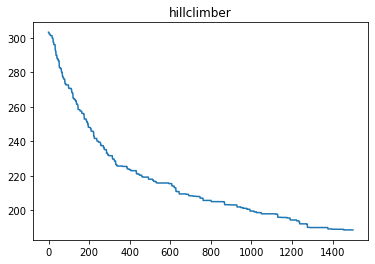

In [7]:
hill_df, best_solution = random_start_hillclimber(joined, all_households, rel_poi_df, df_afstandn2)

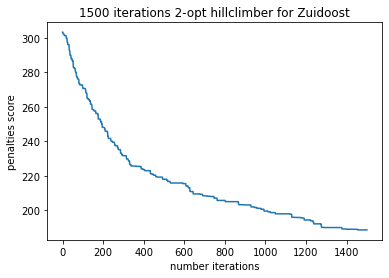

In [11]:
plt = hill_df['best'].plot(title='1500 iterations 2-opt hillclimber for Zuidoost')
plt.set_xlabel('number iterations')
plt.set_ylabel('penalties score')
plt.figure.savefig('20200503hillclimber2-opt.pdf')

In [ ]:
from Code.algorithms import random_shuffling_clusters
from Code.algorithms import best_of_random
from Code.algorithms import hillclimber
from Code.helper_functions import analyze_candidate_solution

In [ ]:
i = int(input("How many random iterations?"))
j = int(input("How many iterations hillclimber?"))
to_save = bool(input("Do you want the results saved(True/False)?"))
clean = bool(input("Do you want to only use a subset of data?"))
use_count = bool(input("Do you want to use addresses instead of clusters?"))
parameter = str(input("What parameter to optimize on (score/penalties)?"))
print(i, j, to_save, clean, use_count, parameter)
print(type(clean))


hill_df, best_solution = hillclimber(10, joined, all_households, \
        rel_poi_df, df_afstandn2, clean=clean, use_count=use_count,\
        parameter=parameter, save=to_save)